In [ ]:
# default_exp modeling

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling

> This module contains custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your huggingface models trained via fastai

In [ ]:
#export
import ast

from blurr.utils import *
from blurr.data import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Base splitter and model wrapper

In [ ]:
#export
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
show_doc(hf_splitter)

<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**)

Splits the huggingface model based on various model architecture conventions

In [ ]:
#export
class HF_BaseModelCallback(Callback):
    
    def begin_fit(self):
        self.hf_model = self.model
        self.hf_model_fwd_args = self.model.forward.__code__.co_varnames
    
    def begin_batch(self):
        x = self.xb[0]
        model_args = [x[0]]
        if (self._include_arg('attention_mask', x[2])): model_args.append(x[2])
        if (self._include_arg('token_type_ids', x[1])): model_args.append(x[1])

        self.learn.xb = tuplify(model_args)
    
    def after_pred(self): 
        self.learn.pred = self.pred[0]
        
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

In [ ]:
#export
class HF_BaseModelWrapper(Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        self.hf_model_fwd_args = hf_model.forward.__code__.co_varnames
        
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs[0]
    
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

Note that `HF_baseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

## Examples

### Sequence classification

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
task = HF_TASKS_AUTO.ForSequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)

In [ ]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['text']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    CategoryBlock
)

# can't export lambda functions, so made the getter a standard method
def get_x(x): 
    return x.text0

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower east side, and an idyllic storyline would make the film critic proof. He was right, but it didn't fool me. Raising Victor Vargas is the story about a seventeen-year old boy called, you guessed it, Victor Vargas (Victor Rasuk) who lives his teenage years chasing more skirt than the Rolling Stones could do in all the years they've toured. The movie starts off in `Ugly Fat' Donna's bedroom where Victor is sure to seduce her, but a cry from outside disrupts his plans when his best-friend Harold (Kevin Rivera) comes-a-looking for him. Caught in the attempt by Harold and his sister, Victor Vargas runs off for damage control. Yet even with the embarrassing implication that he's been boffing the homeliest girl in the neighborhood, nothing dissuades young Victor from going off on the hunt for more fresh meat. On a hot, New York City day they make way to the local public swimming pool where Victor's eyes catch a glimpse of the lovely young nymph Judy (Judy Marte), who's not just pretty, but a strong and independent too. The relationship that develops between Victor and Judy becomes the focus of the film. The story also focuses on Victor's family that is comprised of his grandmother or abuelita (Altagracia Guzman), his brother Nino (also played by real life brother to Victor, Silvestre Rasuk) and his sister Vicky (Krystal Rodriguez). The action follows Victor between scenes with Judy and scenes with his family. Victor tries to cope with being an oversexed pimp-daddy, his feelings for Judy and his grandmother's conservative Catholic upbringing.<br /><br />The problems that arise from Raising Victor Vargas are a few, but glaring errors. Throughout the film you get to know certain characters like Vicky, Nino, Grandma,",negative
1,"I watched Grendel the other night and am compelled to put together a Public Service Announcement.<br /><br />Grendel is another version of Beowulf, the thousand-year-old Anglo-Saxon epic poem. The SciFi channel has a growing catalog of inoffensive and uninteresting movies, and the previews promised an inauthentic low-budget mini-epic, but this one refused to let me switch channels. It was staggeringly, overwhelmingly, bad. I watched in fascination and horror at the train wreck you couldn't tear your eyes away from. I reached for a notepad and managed to capture part of what I was seeing. The following may contain spoilers or might just save your sanity. You've been warned.<br /><br />- Just to get it over with, Beowulf's warriors wore horned helmets. Trivial issue compared to what came after. It also appears that the helmets were in a bin and handed to whichever actor wandered by next. Fit, appearance and function were apparently irrelevant.<br /><br />- Marina Sirtis had obviously been blackmailed into doing the movie by the Ringling Brothers, Barnum and Bailey circus. She managed to avoid a red rubber nose, but the clowns had already done the rest of her makeup.<br /><br />- Ben Cross pretended not to be embarrassed as the king. His character, Hrothgar, must have become king of the Danes only minutes before the film opened and hadn't had a chance to get the crown resized to fit him yet.<br /><br />- To facilitate the actors' return to their day jobs waiting tables, none were required to change their hairstyles at all. The variety of hair included cornrows, sideburns, buzz cuts and a mullet and at least served to distract from the dialog. To prove it was a multi-national cast, all were encouraged to retai

Using the `HF_BaseModelWrapper` approach ...

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

`.to_fp16()` requires a GPU so had to remove for tests to run on github

Using `HF_BaseModelCallback` approach for improved integration with fastai ...

In [ ]:
learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.007585775572806597)

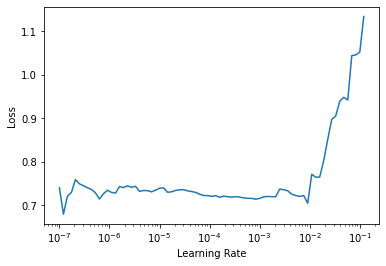

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.723250,0.661623,0.535000,00:19
1,0.613713,0.565825,0.840000,00:19
2,0.537276,0.533030,0.815000,00:19


And here we creat a @typedispatched impelmentation of `Learner.show_results`.

In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')),*s[1:]) 
                          for inp, s in zip(x[0], samples))
    
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)

    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]
        
    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original movie are not going to think much of this one...and those who have never been exposed to either, and who are big fans of Hollywood's current trend towards ""special effects"" being the first and last word in how ""good"" a film is, are going to love it.<br /><br />Things I did not like about this adaption:<br /><br />1. It was NOT a true adaption of the book. From the articles I had read, this movie was supposed to cover other aspects in the book that the first one never got around to. And, that seemed reasonable, no film can cover a book word for word unless it is the length of THE STAND! (And not even then) But, there were things in this movie that were never by any means ever mentioned or even hinted at, in the movie. Reminded me of the way they decided to kill off the black man in the original movie version of THE SHINING. I didn't like that, either. What the movie's press release SHOULD have said is...""We got the basic, very basic, idea from Shirley Jackson's book, we kept the same names of the house and several (though not all) of the leading character's names, but then we decided to write our own story, and, what the heck, we watched THE CHANGELING and THE SHINING and GHOST first, and decided to throw in a bit of them, too.""<br /><br />2. They completely lost the theme of a parapyschologist inviting carefully picked guest who had all had brushes with the paranormal in their pasts, to investigate a house that truly seemed to have been ""born bad"". No, inst

In [ ]:
learn.predict('I really liked the movie')

('positive', tensor(1), tensor([0.4943, 0.5057]))

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.309076,0.254490,0.910000,00:49
1,0.256856,0.239956,0.925000,00:49
2,0.073604,0.301430,0.910000,00:50


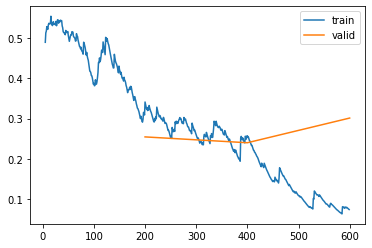

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geisha filtered through their own ignorance and misconceptions. So what is this movie if it isn't about Japan or geisha? Is it pure fantasy as so many people have said? Yes, but then why make it into an American fantasy?<br /><br />There were so many missed opportunities. Imagine a culture where there are no puritanical hang-ups, no connotations of sin about sex. Sex is natural and normal. How is sex handled in this movie? Right. Like it was dirty. The closest thing to a sex scene in the movie has Sayuri wrinkling up her nose and grimacing with distaste for five seconds as if the man trying to mount her had dropped a handful of cockroaches on her crotch. <br /><br />Does anyone actually enjoy sex in this movie? Nope. One character is said to be promiscuous but all we see is her pushing away her lover because it looks like she doesn't want to get caught doing something dirty. Such typical American puritanism has no place in a movie about Japanese geisha.<br /><br />Did Sayuri enjoy her first ravishing by some old codger after her cherry was auctioned off? Nope. She lies there like a cold slab of meat on a chopping block. Of course she isn't supposed to enjoy it. And that is what I mean about this movie. Why couldn't they have given her something to enjoy? Why does all the sex have to be sinful and wrong?<br /><br />Behind Mameha the Chairman was Sayuri's secret patron, and as such he was behind the auction of her virginity. He could have rigged the auction and won her himself. Nobu didn't even bid. So why did the Chairman let that old codger win her and, reeking of old-man stink, get his fingers all over her naked body? Would any woman ever really forgive a man for that?<br /><br />Let's",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original movie are not going to think much of this one...and those who have never been exposed to either, and who are big fans of Hollywood's current trend towards ""special effects"" being the first and last word in how ""good"" a film is, are going to love it.<br /><br />Things I did not like about this adaption:<br /><br />1. It was NOT a true adaption of the book. From the articles I had read, this movie was supposed to cover other aspects in the book that the first one never got around to. And, that seemed reasonable, no film can cover a book word for word unless it is the length of THE STAND! (And not even then) But, there were things in this movie that were never by any means ever mentioned or even hinted at, in the movie. Reminded me of the way they decided to kill off the black man in the original movie version of THE SHINING. I didn't like that, either. What the movie's press release SHOULD have said is...""We got the basic, very basic, idea from Shirley Jackson's book, we kept the same names of the house and several (though not all) of the leading character's names, but then we decided to write our own story, and, what the heck, we watched THE CHANGELING and THE SHINING and GHOST first, and decided to throw in a bit of them, too.""<br /><br />2. They completely lost the theme of a parapyschologist inviting carefully picked guest who had all had brushes with the paranormal in their pasts, to investigate a house that truly seemed to have been ""born bad"". No, inst

In [ ]:
learn.predict("This was a really good movie, ")

('positive', tensor(1), tensor([0.0189, 0.9811]))

In [ ]:
learn.predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([0.9883, 0.0117]))

And what about inference?

In [ ]:
learn.export(fname='seq_class_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.9694, 0.0306]))

### Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    def after_pred(self): 
        self.learn.pred = self.pred

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
path = Path('./')
squad_df = pd.read_csv(path/'squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)


# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"

# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name,  task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
def pre_process_squad(row):
    context, qst, ans = row['context'], row['question_text'], row['answer_text']
    
    add_prefix_space = hf_arch in ['gpt2', 'roberta']
    
    if(hf_tokenizer.padding_side == 'right'):
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(qst, context, 
                                                                           add_prefix_space=add_prefix_space))
    else:
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(context, qst, 
                                                                           add_prefix_space=add_prefix_space))
                                                                       
    tok_ans = hf_tokenizer.tokenize(str(row['answer_text']), 
                                    add_special_tokens=False, 
                                    add_prefix_space=add_prefix_space)
    
    start_idx, end_idx = 0,0
    for idx, tok in enumerate(tok_input):
        try:
            if (tok == tok_ans[0] and tok_input[idx:idx + len(tok_ans)] == tok_ans): 
                start_idx, end_idx = idx, idx + len(tok_ans)
                break
        except: pass
            
    row['tokenized_input'] = tok_input
    row['tokenized_input_len'] = len(tok_input)
    row['tok_answer_start'] = start_idx
    row['tok_answer_end'] = end_idx
    
    return row

In [ ]:
squad_df = squad_df.apply(pre_process_squad, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#hide
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33,"[[CLS], what, does, f, ##d, ##ny, stand, for, ?, [SEP], the, new, york, city, fire, department, (, f, ##d, ##ny, ), ,, provides, fire, protection, ,, technical, rescue, ,, primary, response, to, biological, ,, chemical, ,, and, radioactive, hazards, ,, and, emergency, medical, services, for, the, five, boroughs, of, new, york, city, ., the, new, york, city, fire, department, is, the, largest, municipal, fire, department, in, the, united, states, and, the, second, largest, in, the, world, after, the, tokyo, fire, department, ., the, f, ##d, ##ny, employs, approximately, 11, ,, 08, ##0, unif...",123,11,16
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485,"[[CLS], in, what, year, did, the, ottomans, destroy, lima, ##sso, ##l, ?, [SEP], following, the, death, in, 147, ##3, of, james, ii, ,, the, last, lu, ##si, ##gnan, king, ,, the, republic, of, venice, assumed, control, of, the, island, ,, while, the, late, king, ', s, venetian, widow, ,, queen, catherine, corn, ##aro, ,, reigned, as, figure, ##head, ., venice, formally, annexed, the, kingdom, of, cyprus, in, 148, ##9, ,, following, the, abd, ##ication, of, catherine, ., the, venetian, ##s, fortified, nico, ##sia, by, building, the, venetian, walls, ,, and, used, it, as, an, important, comm...",139,110,112


In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'
txt_cols = [['question_text'],['context']] if (hf_tokenizer.padding_side == 'right') else [['context'],['question_text']]

# override HF_BatchTransform defaults (optional)
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, task=ForQuestionAnsweringTask(),
                                 max_seq_len=128, truncation_strategy=trunc_strat)

blocks = (
    HF_TextBlock.from_df(text_cols_lists=txt_cols, 
                         hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, hf_batch_tfm=hf_batch_tfm),
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

# can't export lambda functions, so made the getter a standard method
def get_x(x): return (x.text0, x.text1)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[1], dls.vocab[2]

(3, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_
0,"along with northeast africa, southeast asia and india, what locale had a significant influence on somali culture? the culture of somalia is an amalgamation of traditions developed independently and through interaction with neighbouring and far away civilizations, such as other parts of northeast africa, the arabian peninsula, india and southeast asia.",52,55
1,"what did the raf conclude? the relieved british began to assess the impact of the blitz in august 1941, and the raf air staff used the german experience to improve bomber command's offensives. they concluded bombers should strike a single target each night and use more incendiaries because they had a greater impact on production than high explosives. they also noted regional production was severely disrupted when city centres were devastated through the loss of administrative offices, utilities and transport. they believed the luftwaffe had failed in precision attack, and concluded the german example of area attack using incendiaries was the way forward for operations over germany.",43,69


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

In [ ]:
learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


If we are using the callback, like we are here, we have to unpack the `HF_baseInput` (the `x` returned from `dls.one_batch()` list into a tuple (which is what `*x` will do) since the `learn.model` below is in this case a huggingface transformer model (not a wrapper).

In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(*x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=6.309573450380412e-07)

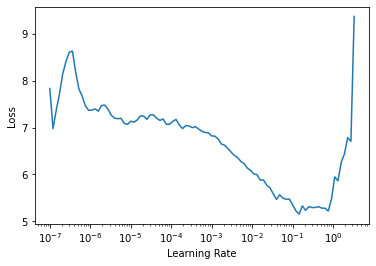

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.352720,3.117157,00:05
1,2.786176,2.520209,00:05
2,2.240896,2.410746,00:05


In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,category,category_,target1,target2
0,"what covers crimes of human against human? tort law covers the entire imaginable spectrum of wrongs which humans can inflict upon each other, and of course, partially overlaps with wrongs also punishable by criminal law. although the american law institute has attempted to standardize tort law through the development of several versions of the restatement of torts, many states have chosen to adopt only certain sections of the restatements and to reject others. thus, because of its immense size and diversity, american tort law cannot be easily summarized.",10,13,10,31
1,"along with electricity, what sometimes powers beer pumps that aren't operated by hand? strictly the term refers to the pump itself, which is normally manually operated, though electrically powered and gas powered pumps are occasionally used. when manually powered, the term "" handpump "" is often used to refer to both the pump and the associated handle.",38,39,38,39


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text0': 'What did George Lucas make?',
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '12'),
 tensor([11]),
 tensor([[1.7503e-06, 1.5670e-06, 9.5718e-08, 2.3981e-07, 1.2567e-07, 1.7987e-07,
          1.0043e-08, 1.7503e-06, 3.7886e-04, 2.4048e-05, 1.2176e-03, 9.9803e-01,
          5.5433e-05, 5.2092e-06, 2.3277e-05, 1.7575e-06, 1.3494e-04, 8.6273e-05,
          6.1755e-07, 2.5187e-05, 2.3130e-06, 1.7498e-06, 1.7560e-06, 6.0479e-09,
          6.6749e-09, 6.2737e-09, 6.2754e-09, 6.3688e-09, 6.6228e-09, 6.6036e-09,
          6.1230e-09, 6.3522e-09, 6.5088e-09, 6.4289e-09, 5.8989e-09, 5.7622e-09,
          6.0739e-09, 6.0981e-09, 5.7869e-09, 5.8004e-09, 5.9001e-09, 6.0937e-09,
          6.2347e-09, 6.0290e-09, 6.3254e-09, 6.3595e-09, 6.3138e-09, 6.1877e-09,
          6.2155e-09, 6.2463e-09, 6.4541e-09, 6.3566e-09, 6.2746e-09, 6.4311e-09,
          6.7621e-09, 6.7669e-09, 6.5901e-09, 6.3335e-09, 6.4125e-09, 6.7932e-09,
          6.6683e-09, 6.2481e-09, 6.0986e-09, 6.3251e-09, 6.7264e-09, 6.3221e-09,
          6.1049e-09, 6.2518e-09, 6.2960e-09, 6.5749e-09, 6.2726e-09

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text0': 'When was Star Wars made?',
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.988786,2.222176,00:15
1,1.798132,2.061344,00:15
2,1.659759,2.030719,00:15


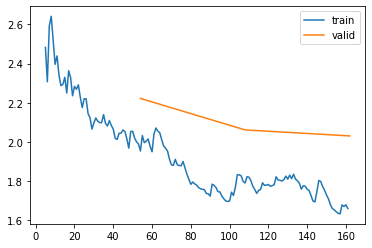

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_,target1,target2
0,"what covers crimes of human against human? tort law covers the entire imaginable spectrum of wrongs which humans can inflict upon each other, and of course, partially overlaps with wrongs also punishable by criminal law. although the american law institute has attempted to standardize tort law through the development of several versions of the restatement of torts, many states have chosen to adopt only certain sections of the restatements and to reject others. thus, because of its immense size and diversity, american tort law cannot be easily summarized.",10,13,10,12
1,"do mandolin notes decay faster or slower than larger string instruments? like any plucked instrument, mandolin notes decay to silence rather than sound out continuously as with a bowed note on a violin, and mandolin notes decay faster than larger stringed instruments like the guitar. this encourages the use of tremolo ( rapid picking of one or more pairs of strings ) to create sustained notes or chords. the mandolin's paired strings facilitate this technique : the plectrum ( pick ) strikes each of a pair of strings alternately, providing a more full and continuous sound than a single string would.",5,6,42,43


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[6.3500e-06, 7.8405e-06, 7.7379e-07, 5.4203e-07, 2.7365e-07, 2.2018e-06,
          1.6494e-07, 6.3501e-06, 7.8422e-05, 1.6479e-05, 8.2368e-05, 1.7593e-04,
          4.5506e-06, 7.4108e-03, 9.9218e-01, 3.6430e-06, 2.7446e-06, 2.4079e-06,
          2.4886e-07, 1.6084e-06, 1.4878e-06, 6.3481e-06, 6.3576e-06, 2.5284e-08,
          2.8472e-08, 2.6864e-08, 2.6833e-08, 2.6348e-08, 2.6949e-08, 2.5775e-08,
          2.5776e-08, 2.5637e-08, 2.7819e-08, 2.7683e-08, 2.5564e-08, 2.5468e-08,
          2.5793e-08, 2.5617e-08, 2.5298e-08, 2.5354e-08, 2.4667e-08, 2.4978e-08,
          2.5855e-08, 2.5493e-08, 2.5532e-08, 2.5792e-08, 2.5203e-08, 2.5326e-08,
          2.5500e-08, 2.5257e-08, 2.7466e-08, 2.6320e-08, 2.5992e-08, 2.6242e-08,
          2.6348e-08, 2.7032e-08, 2.6362e-08, 2.6091e-08, 2.5739e-08, 2.8439e-08,
          2.8358e-08, 2.6403e-08, 2.6138e-08, 2.6267e-08, 2.6787e-08, 2.5986e-08,
          2.6007e-08, 2.5580e-08, 2.5584e-08, 2.8549e-08, 2.6020e-08

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'text0': 'Who created Star Wars?', 
     'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('7', '9'),
 tensor([7]),
 tensor([[1.8297e-06, 4.0223e-07, 1.1257e-07, 5.8191e-07, 9.6678e-08, 3.2013e-08,
          1.8299e-06, 9.9918e-01, 7.3585e-04, 2.0745e-06, 2.4487e-05, 4.7254e-07,
          3.3272e-06, 3.0202e-05, 3.1279e-07, 1.3459e-05, 8.9659e-07, 7.3047e-08,
          4.9519e-07, 2.2715e-07, 1.8295e-06, 1.8173e-06, 8.6020e-09, 9.9822e-09,
          9.1558e-09, 9.0049e-09, 9.1852e-09, 9.1509e-09, 9.1999e-09, 8.7776e-09,
          8.6928e-09, 1.0244e-08, 9.8885e-09, 8.7605e-09, 8.4360e-09, 8.7013e-09,
          8.6345e-09, 8.5750e-09, 8.8728e-09, 8.6622e-09, 8.7850e-09, 8.9260e-09,
          9.0364e-09, 8.8708e-09, 9.0930e-09, 9.0985e-09, 8.9258e-09, 9.0951e-09,
          9.0377e-09, 9.6011e-09, 9.8522e-09, 9.3892e-09, 9.0854e-09, 9.2266e-09,
          9.3502e-09, 9.3170e-09, 9.1512e-09, 8.9740e-09, 1.0081e-08, 1.0182e-08,
          9.1079e-09, 9.0033e-09, 9.0033e-09, 9.0560e-09, 9.2520e-09, 9.0773e-09,
          9.0336e-09, 8.9581e-09, 9.4025e-09, 9.4740e-09, 9.1077e-09, 9

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

### Token classification

The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image. Named entity recognition (NER) is an example of token classification in the NLP space

In [ ]:
# germ_eval_df = pd.read_csv('./data/task-token-classification/germeval2014ner/germeval2014ner_cleaned.csv')
germ_eval_df = pd.read_csv('./germeval2014_sample.csv')

print(len(germ_eval_df))
germ_eval_df.head()

591005


,pos,token,tag1,tag2,ds_type,seq_id
0,1,Schartau,B-PER,O,train,1
1,2,sagte,O,O,train,1
2,3,dem,O,O,train,1
3,4,"""",O,O,train,1
4,5,Tagesspiegel,B-ORG,O,train,1


We are only going to be working with small sample from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) data set ... so the results might not be all that great :)

In [ ]:
germ_eval_df.dropna(inplace=True)
germ_eval_df[germ_eval_df.token.isna()]

,pos,token,tag1,tag2,ds_type,seq_id


In [ ]:
labels = sorted(germ_eval_df.tag1.unique())
print(labels)

['B-LOC', 'B-LOCderiv', 'B-LOCpart', 'B-ORG', 'B-ORGderiv', 'B-ORGpart', 'B-OTH', 'B-OTHderiv', 'B-OTHpart', 'B-PER', 'B-PERderiv', 'B-PERpart', 'I-LOC', 'I-LOCderiv', 'I-LOCpart', 'I-ORG', 'I-ORGderiv', 'I-ORGpart', 'I-OTH', 'I-OTHderiv', 'I-OTHpart', 'I-PER', 'I-PERderiv', 'I-PERpart', 'O']


In [ ]:
germ_eval_df = germ_eval_df.groupby(by='seq_id').agg(list).reset_index()
germ_eval_df.head(2)

,seq_id,pos,token,tag1,tag2,ds_type
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]","[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]","[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train]"
1,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]","[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train, train]"


After getting rid of troublesom NaNs and getting my labels, the code above converts my input datafame into something I can model by making the token and tag1 columns represent a list of tokens (or labels) for a give sequence.

In [ ]:
task = HF_TASKS_AUTO.ForTokenClassification
pretrained_model_name = "bert-base-multilingual-cased"

config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('bert',
 transformers.tokenization_bert.BertTokenizer,
 transformers.configuration_bert.BertConfig,
 transformers.modeling_bert.BertForTokenClassification)

In [ ]:
test_eq(hf_config.num_labels, len(labels))

In [ ]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['token']], 
                         hf_arch=hf_arch, 
                         hf_tokenizer=hf_tokenizer, 
                         tok_func_mode='list', 
                         task=ForTokenClassificationTask(), max_seq_len=128),
    HF_TokenCategoryBlock(vocab=labels)
)

def get_y(inp):
    return [ (label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.token, inp.tag1) ]

dblock = DataBlock(blocks=blocks, 
                   get_x=lambda x: x.text0,
                   get_y=get_y,
                   splitter=RandomSplitter())

We have to define a `get_y` that creates the same number of labels as there are subtokens for a particular token. For example, my name "Wayde" gets split up into two subtokens, "Way" and "##de". The label for "Wayde" is "B-PER" and we just repeat it for the subtokens.  This all get cleaned up when we show results and get predictions.

In [ ]:
dls = dblock.dataloaders(germ_eval_df, bs=4)

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"Band 1 : November 1918 - November 1923. Pfälzische Verlags - Anstalt, Landau / Pfalz 1992, ISBN 3 - 87629 - 164 - X * Gerhard Gräber, Matthias Spindler : Die Pfalzbefreier : Volkes Zorn und Staatsgewalt im bewaffneten Kampf gegen den pfälzischen Separatismus 1923 / 24.","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'O']"
1,"Anhänger des Hüftschwingers mit der schmucken Tollenfrisur machen Elvis Presley trotz vermeintlich vorgetäuschter Todesmeldungen immer noch in schöner Regelmäßigkeit in Supermärkten, Schnellimbissen und Bekleidungsfachgeschäften für Übergrößen aus.","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


In [ ]:
learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(*b[0])
len(preds),preds[0].shape

(1, torch.Size([4, 128, 25]))

In [ ]:
len(b), len(b[0]), b[0][0].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([4, 128]), 4, torch.Size([4, 128]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([512, 25]) torch.Size([512])


In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.737800812406931e-05)

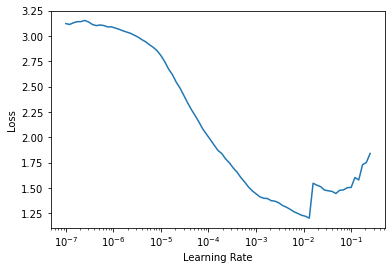

In [ ]:
#slow
learn.unfreeze()
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max= 3e-5, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.069473,0.076172,0.143855,10:41
1,0.053674,0.062299,0.144403,10:43
2,0.020713,0.062300,0.144565,10:44


In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y:HF_TokenTensorCategory, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')), *s[1:]) 
                          for inp, s in zip(x[0], samples))
    
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    for i,ctx in enumerate(ctxs): 
        preds = ast.literal_eval(outs[i][0])
        ctx['target'] = [pred for idx, pred in enumerate(preds) if (y[i][idx] != -100)]
        
    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=20)

,text,category,target
0,"Toyota Fortuner für den philippinischen Markt Das Modell 2. 7 G ist mit dem 2, 7 l - R4 - Motor mit VVTi, Typ Toyota 2TR - FE, ausgestattet, der 160 bhp ( 118 kW ) bei 5. 200 min - 1 und ein Drehmoment von 241 Nm bei 3. 800 min - 1 produziert.","['B-OTH', 'I-OTH', 'O', 'O', 'B-LOCderiv', 'O', 'O', 'O', 'B-OTH', 'I-OTH', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[B-ORG, B-OTH, O, O, B-LOCderiv, O, O, O, I-OTH, I-OTH, O, O, O, O, O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"Tori Spelling will Ehegelöbnis erneuern Tori Spelling & Familie Los Angeles ( dpa ) - « Beverly Hills, 90210 » - Star Tori Spelling ( 36 ) und Ehemann Dean McDermott ( 41 ) werden sich noch einmal ewige Treue schwören.","['B-PER', 'I-PER', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-ORG', 'O', 'O', 'O', 'B-OTH', 'I-OTH', 'I-OTH', 'I-OTH', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[B-PER, I-PER, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, B-ORG, O, O, O, B-OTH, I-OTH, I-OTH, I-OTH, O, O, B-PER, I-PER, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O]"
2,"Auch wenn die Indexqualität nur der zweitwichtigste Punkt bei der Bewertung ist, widmet Scope ihr ein besonderes Augenmerk : Die Ratingagentur prüft, ob der Index tatsächlich repräsentativ für den von ihm abgebildeten Sektor oder Markt ist.","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,"Springer Verlag 1997, S. 2 f. Wichtige Impulse für den Naturschutz folgten durch die Konferenz für Umwelt und Entwicklung der Vereinten Nationen ( UNCED ) 1992. Mit der Einführung des Begriffes "" Sustanibility "" trat die Nutzung von Naturgütern ins Blickfeld.","['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


In [ ]:
res = learn.predict('My name is Wayde and I live in San Diego')
print(res[0])

['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-LOC']


The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer.

In [ ]:
#export
@patch
def predict_tokens(self:Learner, inp, **kargs):
    """Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
    get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input
    """
    pred_lbls, pred_lbl_ids, probs = self.predict(inp)
    
    # grab the huggingface tokenizer from the learner's dls.tfms
    learn_hf_tokenizer = self.dls.tfms[0].tokenizer.filter(lambda tok: isinstance(tok, HF_Tokenizer))[0]
    hf_tokenizer = learn_hf_tokenizer.hf_tokenizer
    add_prefix_space = learn_hf_tokenizer.hf_arch in ['gpt2', 'roberta']
    
    # grab the HF_BatchTransform as well
    learn_hf_batch_transform = learn.dls.before_batch.hf__batch_transform
    
    # convert the `inp` to a list if necessary
    txt_split = inp if isinstance(inp, list) else learn_hf_tokenizer.list_split_func(inp) 

    # calculate the number of subtokens per raw/input token so that we can determine what predictions to
    # return
    subtoks_per_raw_tok = [ (entity, len(hf_tokenizer.tokenize(str(entity), add_prefix_space=add_prefix_space))) 
                           for entity in txt_split ]
    
    # very similar to what HF_BatchTransform does with the exception that we are also grabbing
    # the `special_tokens_mask` to help with getting rid or irelevant predicts for any special tokens
    # (e.g., [CLS], [SEP], etc...)
    txt_toks = [ sub_toks for entity in txt_split 
                for sub_toks in hf_tokenizer.tokenize(entity, add_prefix_space=add_prefix_space) ]
    
    txt_tok_ids = hf_tokenizer.convert_tokens_to_ids(txt_toks)
    
    res = hf_tokenizer.prepare_for_model(txt_tok_ids, None, 
                                         max_length=learn_hf_batch_transform.max_seq_len, 
                                         pad_to_max_length=True,
                                         truncation_strategy=None, 
                                         return_special_tokens_mask=True)
    
    special_toks_msk = L(res['special_tokens_mask'])
    actual_tok_idxs = special_toks_msk.argwhere(lambda el: el != 1)
    
    # using the indexes to the actual tokens, get that info from the results returned above
    pred_lbls_list = ast.literal_eval(pred_lbls)
    actual_pred_lbls = L(pred_lbls_list)[actual_tok_idxs]
    actual_pred_lbl_ids = pred_lbl_ids[actual_tok_idxs]
    actual_probs = probs[actual_tok_idxs]
    
    # now, because a raw token can be mapped to multiple subtokens, we need to build a list of indexes composed
    # of the *first* subtoken used to represent each raw token (that is where the prediction is)
    offset = 0
    raw_trg_idxs = []
    for idx, (raw_tok, sub_tok_count) in enumerate(subtoks_per_raw_tok): 
        raw_trg_idxs.append(idx+offset)
        offset += sub_tok_count-1 if (sub_tok_count > 1) else 0

    return txt_split, actual_pred_lbls[raw_trg_idxs], actual_pred_lbl_ids[raw_trg_idxs], actual_probs[raw_trg_idxs]

In [ ]:
show_doc(Learner.predict_tokens)

<h4 id="Learner.predict_tokens" class="doc_header"><code>Learner.predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.predict_tokens</code>(**`inp`**, **\*\*`kargs`**)

Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input

In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com."

In [ ]:
res = learn.predict_tokens(txt)
print([(tok, lbl) for tok,lbl in zip(res[0],res[1])])

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-OTH')]


It's interesting (and very cool) how well this model performs on English even thought it was trained against a German corpus.

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data.ipynb.
Converted 02_modeling.ipynb.
Converted index.ipynb.
